# Imports

In [1]:
import scipy.io.wavfile as wavfile
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Data preperation

In [2]:
# Defining variables used for reading the data

classes = ["Alarm", "Blender", "Microwave", "Music", "Silence", "Vacuum"]
samples_per_class = 20

## Reading in all data

In [3]:
# Data is stored in a two dimensional list with first dimension beeing the class and the second dimension the samples
data = [[] for _ in range(len(classes))]

for cls_number, cls_name in enumerate(classes):
    path = f"Data/{cls_name}/{cls_name}_"
    for i in range(samples_per_class):
        fs,y=wavfile.read(path + f"{i}.wav")
        data[cls_number].append([fs, y])

C:\Users\Timmy\AppData\Local\Temp\ipykernel_2236\824154626.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs,y=wavfile.read(path + f"{i}.wav")


## Windowing

### Single window

By reading in the data samples as a whole, a single window is already used. So therefore no further implementation is needed for the single window approach.

### Multiple windows (not finished yet)

In [29]:
window_size = 5  # in seconds
overlap = 0.5  # in per cent

data_windowed = [[] for _ in range(len(data))]

for cls_number in range(len(data)):
    for i in range(len(data[cls_number])):
        indexes_per_window = window_size * data[cls_number][i][0]
        end_index = indexes_per_window
        while end_index < len(data[cls_number][i][1]):
            data_windowed[cls_number].append(data[cls_number][i][1][end_index - indexes_per_window:end_index])
            end_index += int((1 - overlap) * indexes_per_window)
        data_windowed[cls_number].append(data[cls_number][i][1][end_index - indexes_per_window:])
print(len(data_windowed[2][15][1]))

## Removing all frequencies above 10 kHz

For preprocessing the data all frequencies above 10 kHz are removed. It is assumed that these higher frequencies are created by noise and therefore do not hold any information about the data. A comparison between the original data and the preprocessed showed that it still sounds the same and looks similar in the time domain, so it is assumed to be safe to remove these frequencies.

In [4]:
for cls_number in range(len(data)):
    for i in range(len(data[cls_number])):
        audio_data = data[cls_number][i][1]
        T = 1/data[cls_number][i][0]
        N = len(audio_data)
        max_val = 1.0/(2.0*T)
        num_vals = N//2  

        yf = fft(audio_data)

        xf = np.linspace(0.0, max_val, num_vals)
        
        i_over_10kHz = np.argmax(xf > 10000)
        yf[i_over_10kHz: len(yf) - i_over_10kHz] = 0.0
        data[cls_number][i][1] = ifft(yf).real

## Creating spectrograms of the data

In [5]:
FFT_SIZE=1024
data_spectrograms = [[] for _ in range(len(data))]
for cls_number in range(len(data)):
    for i in range(len(data[cls_number])):
        f,t,pxx = signal.spectrogram(data[cls_number][i][1], nperseg=FFT_SIZE, fs=data[cls_number][i][0], noverlap=FFT_SIZE/2)
        data_spectrograms[cls_number].append([f, t, pxx])

# Feature engineering

## Binning

In [6]:
num_freq_bins=5
num_time_bins=5

data_spectrograms_binned = [[] for _ in range(len(data))]

for cls_number in range(len(data_spectrograms)):
    for i in range(len(data_spectrograms[cls_number])):
        resized_pxx = cv2.resize(data_spectrograms[cls_number][i][2],(num_time_bins,num_freq_bins))
        data_spectrograms_binned[cls_number].append([data_spectrograms[cls_number][i][0], data_spectrograms[cls_number][i][1], resized_pxx])

## Feature extraction

Chosen features:

- All bins from the binned spectrogram (25 features)
- Three frequencies with the highest magnitude (3 features)
- Mean magnitude of the frequencies (1 feature)
- Median magnitude of the frequencies (1 feature)
- Variance of the magnitudes of the frequencies (1 feature)

In [7]:
def extract_frequency_features(cls_number: int, i: int) -> float:
    audio_data = data[cls_number][i][1]
    T = 1/data[cls_number][i][0]
    N = len(audio_data)
    max_val = 1.0/(2.0*T)
    num_vals = N//2  

    yf_all = fft(audio_data)
    yf = 2.0/N * np.abs(yf_all[0:num_vals])

    xf = np.linspace(0.0, max_val, num_vals)

    sorted_frequencies = np.argsort(yf)
    
    return [xf[sorted_frequencies[-1]], xf[sorted_frequencies[-2]], xf[sorted_frequencies[-3]], np.mean(yf), np.median(yf), np.var(yf)]

data_features = [[] for _ in range(len(data))]

for cls_number in range(len(data_spectrograms_binned)):
    for i in range(len(data_spectrograms_binned[cls_number])):
        features = data_spectrograms_binned[cls_number][i][2].reshape((-1,)).tolist()
        features.extend(extract_frequency_features(cls_number, i))
        data_features[cls_number].append(np.asarray(features))

## Creating labels

In [8]:
data_list = []
labels_list = []

for cls_number in range(len(data_features)):
    for i in range(len(data_features[cls_number])):
        data_list.append(data_features[cls_number][i])
        labels_list.append(cls_number)

## Normalization

Neccesarry for the SVM to achieve 100% testing accuracy, for the Random Forest it does not matters if the data is normalized or not.

In [9]:
scaler = StandardScaler()
data_list = scaler.fit_transform(data_list)

## Create training and test data

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(data_list, labels_list, test_size=0.30, random_state=42)

# ML models

Two machine learning algorithms have been tested for this assignment. Firstly a SVM with a linear kernel, which has a testing accuracy of 100%. Also Random Forest has been implemented and achieves a testing accuracy of 100% as well. In order for the SVM to achieve 100%, the data has to be normalized. For the Random Forest model it does not matter and it achieves 100% with and without normalization.

## Random forest

In [11]:
clf = RandomForestClassifier()
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

print('Testing Accuracy:', accuracy_score(ytest, ypred))

Average Cross Validation Score from Training:
1.0


Confusion Matrix:
[[7 0 0 0 0 0]
 [0 5 0 0 0 0]
 [0 0 7 0 0 0]
 [0 0 0 7 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 0 5]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Testing Accuracy: 1.0


## SVM

In [12]:
clf = SVC(kernel="linear")
clf.fit(xtrain, ytrain)
cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

ypred = clf.predict(xtest)
cm = confusion_matrix(ytest, ypred)
cr = classification_report(ytest, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

print('Testing Accuracy:', accuracy_score(ytest, ypred))

Average Cross Validation Score from Training:
0.9416666666666667


Confusion Matrix:
[[7 0 0 0 0 0]
 [0 5 0 0 0 0]
 [0 0 7 0 0 0]
 [0 0 0 7 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 0 5]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Testing Accuracy: 1.0


# Performance analysis

## Performance visualization

# Data visualization

Tipps for adressing the audio data in the data list:

- First index defines class of data (see classes list at the top)
- Second index is the number of the sample
- Third index decides between sample rate and actual data (0 = sample rate; 1 = audio data)

## Play audio

In [13]:
from IPython.display import Audio

Audio(data=data[3][9][1], rate=data[3][9][0])

## Plot audio in time domain

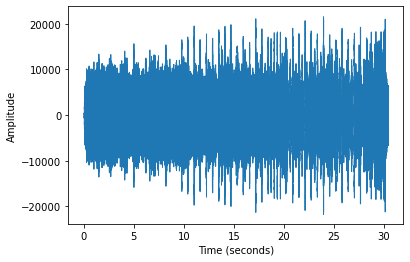

In [14]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

plt.figure()
librosa.display.waveshow(np.asarray(data[3][9][1], dtype=float), sr=data[3][9][0])
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

## Plot audio in frequency domain

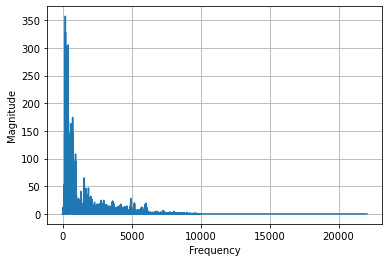

In [15]:
from scipy.fftpack import fft
import matplotlib.pyplot as plt

def fft_method(audio, sampling_rate):
    T = 1/sampling_rate
    N = len(audio)
    max_val = 1.0/(2.0*T)
    num_vals = N//2  
    
    yf_all = fft(audio)
    
    xf = np.linspace(0.0, max_val, num_vals)
    yf = 2.0/N * np.abs(yf_all[0:num_vals])
    
    return xf, yf


xf, yf = fft_method(data[3][9][1], data[3][9][0])

plt.plot(xf, yf)
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

## Plot spectrograms

C:\Users\Timmy\AppData\Local\Temp\ipykernel_2236\3681133312.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_under(color='k', alpha=None)


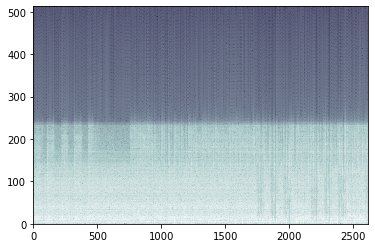

In [26]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
cmap=plt.cm.bone
cmap.set_under(color='k', alpha=None)
plt.pcolormesh(np.log10(data_spectrograms[3][9][2]),cmap=cmap)

## Plot binned spectrograms

C:\Users\Timmy\AppData\Local\Temp\ipykernel_2236\3151999976.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_under(color='k', alpha=None)


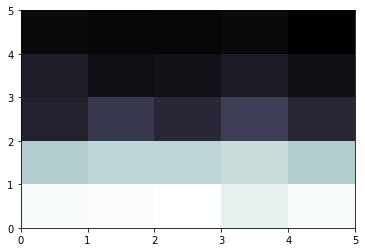

In [27]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
cmap=plt.cm.bone
cmap.set_under(color='k', alpha=None)
plt.pcolormesh(np.log10(data_spectrograms_binned[3][9][2]),cmap=cmap)

## Plot binned spectrograms of all classes

In [18]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
cmap=plt.cm.bone
cmap.set_under(color='k', alpha=None)

C:\Users\Timmy\AppData\Local\Temp\ipykernel_2236\3670946234.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_under(color='k', alpha=None)


### Alarm

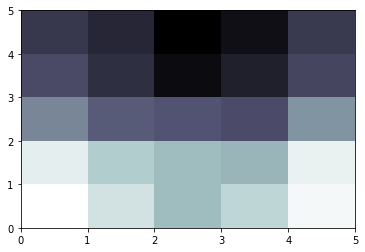

In [19]:
plt.pcolormesh(np.log10(data_spectrograms_binned[0][0][2]),cmap=cmap)

### Blender

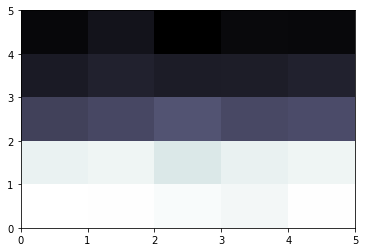

In [20]:
plt.pcolormesh(np.log10(data_spectrograms_binned[1][0][2]),cmap=cmap)

### Microwave

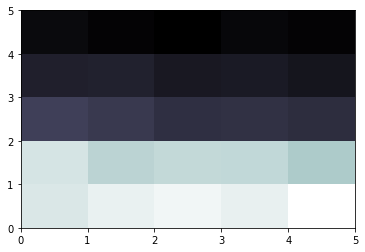

In [21]:
plt.pcolormesh(np.log10(data_spectrograms_binned[2][0][2]),cmap=cmap)

### Music

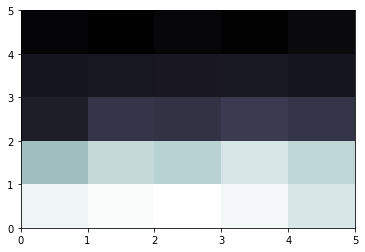

In [22]:
plt.pcolormesh(np.log10(data_spectrograms_binned[3][0][2]),cmap=cmap)

### Silence

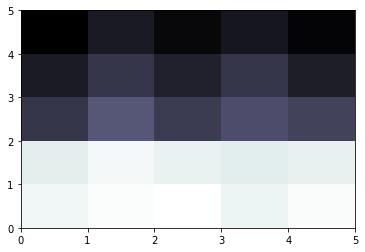

In [23]:
plt.pcolormesh(np.log10(data_spectrograms_binned[4][0][2]),cmap=cmap)

### Vacuum

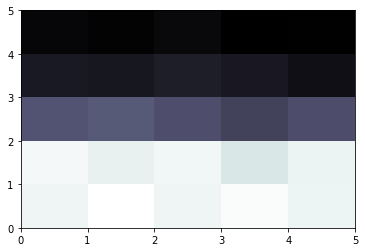

In [24]:
plt.pcolormesh(np.log10(data_spectrograms_binned[5][0][2]),cmap=cmap)